In [144]:
# Import relevant libraries.
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob


# Ensure required NLTK resources are present (quiet=True => no console spam)
for pkg in [
    "punkt",
    "stopwords",
    "vader_lexicon",
]:
    nltk.download(pkg, quiet=True)

import warnings
warnings.filterwarnings("ignore")

In [145]:
# Load & initial tidy-up    

# Raw data set of central‑bank speeches
speeches = pd.read_csv("all_speeches.csv")

# Robust datetime parsing
speeches["date"] = pd.to_datetime(speeches["date"], errors="coerce")

# Period of interest: 1997‑01‑01 → 2022‑12‑31
speeches = speeches[speeches["date"].between("1997-01-01", "2022-12-31")]

In [146]:
# Basic Exploration
print("Dataset shape:", speeches.shape)
print("\nColumns:", speeches.columns.tolist())
print("\nFirst 5 rows of the data:")
speeches.head()

Dataset shape: (7665, 7)

Columns: ['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text']

First 5 rows of the data:


,reference,country,date,title,author,is_gov,text
36,r970205a_BOA,australia,1997-02-05,,macfarlane,1,When Alan Cameron invited me to speak at a con...
37,r970211a_BOA,australia,1997-02-11,,macfarlane,1,It is a great pleasure to be speaking at The S...
38,r970508a_BOA,australia,1997-05-08,,macfarlane,1,"Thank you, Mr Chairman. It is a pleasure for m..."
39,r970515a_BOA,australia,1997-05-15,,macfarlane,1,"It is a pleasure to be here in Melbourne, and ..."
40,r970812a_BOA,australia,1997-08-12,,macfarlane,1,It is a pleasure to be in Perth to address the...


In [147]:
# Data Validation
print("\nData types:")
print(speeches.dtypes)

print("\nMissing values per column:")
print(speeches.isnull().sum())


Data types:
reference            object
country              object
date         datetime64[ns]
title                object
author               object
is_gov                int64
text                 object
dtype: object

Missing values per column:
reference    0
country      0
date         0
title        0
author       0
is_gov       0
text         0
dtype: int64


In [148]:
# is_gov (Edward George) 
# Clean author strings and initialise `is_gov`
speeches["author"] = speeches["author"].fillna("").str.strip()
speeches["is_gov"] = speeches["is_gov"].fillna(0)  

# Governor Sir Edward George held office 01‑Jul‑1993 → 30‑Jun‑2003
mask_george = (
    speeches["author"].str.lower().str.contains("george")
    & (speeches["date"] >= "1993-07-01")
    & (speeches["date"] <= "2003-06-30")
)
speeches.loc[mask_george, "is_gov"] = 1

In [149]:
# Bank OF England (UK) Speeches Only  
boe_speeches = speeches[speeches["country"].str.lower() == "united kingdom"].copy()
boe_speeches

,reference,country,date,title,author,is_gov,text
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased..."
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc..."
...,...,...,...,...,...,...,...
6165,r221007a_BOE,united kingdom,2022-10-07,"Shocks, inflation, and the policy response",ramsden,0,Thank you very much for the invitation to spea...
6166,r221012a_BOE,united kingdom,2022-10-12,Monetary policy: an anchor in challenging times,pill,0,Huw Pill talks about how we will bring inflati...
6167,r221015a_BOE,united kingdom,2022-10-15,Monetary policy and financial stability interv...,bailey,1,We are meeting in the most difficult of times....
6168,r221019a_BOE,united kingdom,2022-10-19,"Governance of “Decentralised” Finance: Get up,...",wilkins,0,"These are divided into seven categories, suffr..."


In [186]:
boe_speeches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1209 entries, 4961 to 6169
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   reference                1209 non-null   object        
 1   country                  1209 non-null   object        
 2   date                     1209 non-null   datetime64[ns]
 3   title                    1209 non-null   object        
 4   author                   1209 non-null   object        
 5   is_gov                   1209 non-null   int64         
 6   text                     1209 non-null   object        
 7   year                     1209 non-null   int32         
 8   month                    1209 non-null   int32         
 9   speech_length            1209 non-null   int64         
 10  cleaned_text             1209 non-null   object        
 11  Negative                 1209 non-null   int64         
 12  Positive                 1209 non-nu

In [150]:
# Splitting "date" & identify lenght speech    
boe_speeches["year"] = boe_speeches["date"].dt.year
boe_speeches["month"] = boe_speeches["date"].dt.month
boe_speeches["speech_length"] = boe_speeches["text"].str.split().apply(len)
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year,month,speech_length
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998,9,2387
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998,10,4045
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998,10,2311
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998,11,4690
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998,11,4452


In [163]:
# Text Pre-processing (clean & tokenise)

STOP_WORDS = set(stopwords.words("english"))

def clean(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\d+", " ", text.lower())  # drop numerals
    text = re.sub(r"[^\w\s]", " ", text)     # drop punctuation
    tokens = [t for t in word_tokenize(text) if t not in STOP_WORDS]
    return " ".join(tokens)

boe_speeches["cleaned_text"] = boe_speeches["text"].apply(clean)

boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year,month,speech_length,cleaned_text
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998,9,2387,thank chairman actually pleased opportunity re...
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998,10,4045,great pleasure beautiful city bruges honoured ...
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998,10,2311,industries suffered volatility british economy...
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998,11,4690,topic evening use forecasts economic policy ma...
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998,11,4452,six years ago week sterling left exchange rate...


In [167]:
# Lexicon-based sentiment 

sentiment_lexicon = pd.read_excel("LSE_DA_BoE_Employer_project_Sentiment-labelled_wordlist-2.xlsx")
categories = [
     "Negative",
     "Positive",
     "Uncertainty",
     "Litigious",
     "Strong",
     "Weak",
     "Constraining",
 ]
word_sets = {
    cat: set(sentiment_lexicon.loc[sentiment_lexicon[cat] == 1, "Word"].str.lower())
    for cat in categories
}

def lexicon_counts(text: str) -> pd.Series:
    tokens = re.findall(r"\b\w+\b", str(text).lower())
    return pd.Series({cat: sum(t in word_sets[cat] for t in tokens) for cat in categories})

boe_speeches = pd.concat(
    [boe_speeches, boe_speeches["text"].apply(lexicon_counts)], axis=1
 )
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year,month,speech_length,cleaned_text,Negative,Positive,Uncertainty,Litigious,Strong,Weak,Constraining
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998,9,2387,thank chairman actually pleased opportunity re...,63,39,24,3,20,16,2
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998,10,4045,great pleasure beautiful city bruges honoured ...,87,82,52,6,39,30,16
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998,10,2311,industries suffered volatility british economy...,61,33,49,2,11,17,5
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998,11,4690,topic evening use forecasts economic policy ma...,78,43,92,11,31,42,15
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998,11,4452,six years ago week sterling left exchange rate...,102,46,119,22,20,49,12


In [182]:
# Vader 
sia = SentimentIntensityAnalyzer()
vader_scores = boe_speeches["cleaned_text"].apply(sia.polarity_scores).apply(pd.Series)
boe_speeches = pd.concat([boe_speeches, vader_scores], axis=1)

boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year,month,speech_length,...,neu,pos,compound,polarity,subjectivity,Sentiment Label (VADER),neg,neu,pos,compound
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998,9,2387,...,0.688,0.172,0.9952,0.083288,0.435206,Positive,0.140,0.688,0.172,0.9952
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998,10,4045,...,0.679,0.221,0.9998,0.076868,0.368726,Positive,0.100,0.679,0.221,0.9998
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998,10,2311,...,0.717,0.176,0.9977,0.091432,0.394993,Positive,0.107,0.717,0.176,0.9977
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998,11,4690,...,0.780,0.150,0.9996,0.086707,0.476692,Positive,0.070,0.780,0.150,0.9996
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998,11,4452,...,0.774,0.135,0.9990,0.058314,0.393456,Positive,0.090,0.774,0.135,0.9990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165,r221007a_BOE,united kingdom,2022-10-07,"Shocks, inflation, and the policy response",ramsden,0,Thank you very much for the invitation to spea...,2022,10,4161,...,0.785,0.118,0.9879,0.102899,0.401096,Positive,0.096,0.785,0.118,0.9879
6166,r221012a_BOE,united kingdom,2022-10-12,Monetary policy: an anchor in challenging times,pill,0,Huw Pill talks about how we will bring inflati...,2022,10,3567,...,0.771,0.163,0.9996,0.091845,0.426859,Positive,0.066,0.771,0.163,0.9996
6167,r221015a_BOE,united kingdom,2022-10-15,Monetary policy and financial stability interv...,bailey,1,We are meeting in the most difficult of times....,2022,10,1767,...,0.727,0.137,-0.7821,0.105896,0.426665,Negative,0.135,0.727,0.137,-0.7821
6168,r221019a_BOE,united kingdom,2022-10-19,"Governance of “Decentralised” Finance: Get up,...",wilkins,0,"These are divided into seven categories, suffr...",2022,10,5382,...,0.771,0.183,0.9999,0.124242,0.479746,Positive,0.046,0.771,0.183,0.9999


In [169]:
# Sentiment per year
vader_yearly = (
    boe_speeches
      .groupby('year')[['compound', 'pos', 'neg', 'neu']]
      .mean()
      .round(3)           
                  
)

print("\nAverage VADER sentiment per year:")
vader_yearly


Average VADER sentiment per year:


,compound,pos,neg,neu
year,,,,
1998,0.997,0.168,0.108,0.723
1999,0.932,0.176,0.099,0.725
2000,0.944,0.205,0.087,0.708
2001,0.943,0.182,0.104,0.714
2002,0.930,0.194,0.106,0.700
2003,0.788,0.181,0.102,0.717
2004,0.858,0.173,0.092,0.734
2005,0.995,0.166,0.091,0.743
2006,0.823,0.172,0.097,0.731


In [188]:
# Textblob Polarity & subjectivity.
def generate_polarity_subjectivity(dfs):
    dft2 = TextBlob(dfs).sentiment
    return pd.Series([dft2[0], dft2[1]])

# Apply the function to the data and add two new columns
boe_speeches[['polarity','subjectivity']] = boe_speeches['text'].apply(generate_polarity_subjectivity)
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year,month,speech_length,...,neu,pos,compound,polarity,subjectivity,Sentiment Label (VADER),neg,neu,pos,compound
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998,9,2387,...,0.688,0.172,0.9952,0.083288,0.435206,Positive,0.140,0.688,0.172,0.9952
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998,10,4045,...,0.679,0.221,0.9998,0.076868,0.368726,Positive,0.100,0.679,0.221,0.9998
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998,10,2311,...,0.717,0.176,0.9977,0.091432,0.394993,Positive,0.107,0.717,0.176,0.9977
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998,11,4690,...,0.780,0.150,0.9996,0.086707,0.476692,Positive,0.070,0.780,0.150,0.9996
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998,11,4452,...,0.774,0.135,0.9990,0.058314,0.393456,Positive,0.090,0.774,0.135,0.9990


In [171]:
def label_vader(c, thr=0.05):
    if c >  thr:
        return "Positive"
    if c < -thr:
        return "Negative"
    return "Neutral"

boe_speeches["Sentiment Label (VADER)"] = boe_speeches["compound"].apply(label_vader)
boe_speeches.head()

,reference,country,date,title,author,is_gov,text,year,month,speech_length,...,Strong,Weak,Constraining,neg,neu,pos,compound,polarity,subjectivity,Sentiment Label (VADER)
4961,r980915a_BOE,united kingdom,1998-09-15,Speech,george,1,"Thank you, Chairman. I'm actually very pleased...",1998,9,2387,...,20,16,2,0.140,0.688,0.172,0.9952,0.083288,0.435206,Positive
4962,r981021b_BOE,united kingdom,1998-10-21,Britain in Europe,george,1,It's a great pleasure to be here in the beauti...,1998,10,4045,...,39,30,16,0.100,0.679,0.221,0.9998,0.076868,0.368726,Positive
4963,r981021a_BOE,united kingdom,1998-10-21,Impact of the recent turbulence in internation...,king,1,Few industries have suffered more from volatil...,1998,10,2311,...,11,17,5,0.107,0.717,0.176,0.9977,0.091432,0.394993,Positive
4964,r981101a_BOE,united kingdom,1998-11-01,"Economic policy, with and without forecasts",budd,0,My topic this evening is the use of forecasts ...,1998,11,4690,...,31,42,15,0.070,0.780,0.150,0.9996,0.086707,0.476692,Positive
4965,r981101b_BOE,united kingdom,1998-11-01,Inflation targeting in practice: the UK experi...,vickers,0,"Six years ago this week, sterling left the exc...",1998,11,4452,...,20,49,12,0.090,0.774,0.135,0.9990,0.058314,0.393456,Positive


In [206]:
# TextBlob  (polarity & subjectivity) per year
tb_yearly = (
    boe_speeches
        .groupby("year")[["polarity", "subjectivity"]]   
        .mean()                                          
        .round(3)                                        
)

print("\nAverage TextBlob polarity & subjectivity per year:")
tb_yearly


Average TextBlob polarity & subjectivity per year:


,polarity,subjectivity
year,,
1998,0.082,0.415
1999,0.091,0.407
2000,0.118,0.428
2001,0.099,0.421
2002,0.101,0.420
2003,0.098,0.417
2004,0.087,0.412
2005,0.093,0.429
2006,0.090,0.413


In [173]:
# Visualisations

# Speech count per year
fig1 = px.histogram(
    boe_speeches,
    x="year",
    nbins=23,
    title="Number of Bank of England speeches per year (1997–2022)",
)
fig1.update_layout(bargap=0.2)
 
fig1.show()

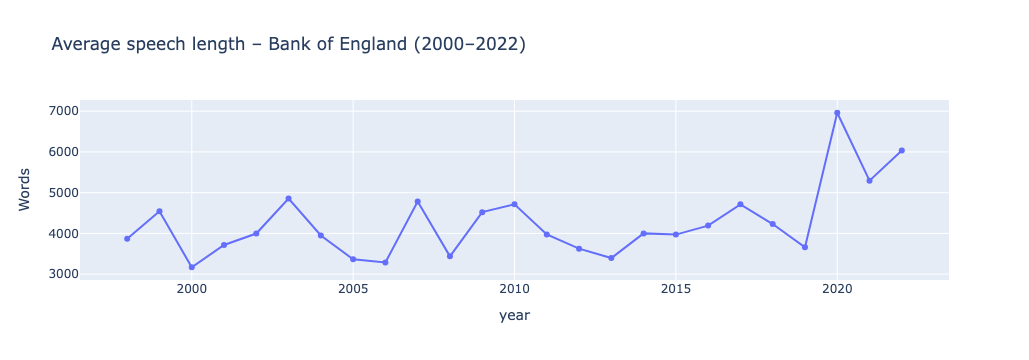

In [178]:
# Average speech length per year
length_by_year = (
     boe_speeches.groupby("year")["speech_length"].mean().reset_index()
)
fig2 = px.line(
     length_by_year,
     x="year",
     y="speech_length",
     title="Average speech length – Bank of England (2000–2022)",
     labels={"speech_length": "Words"},
)
fig2.update_traces(mode="lines+markers")
fig2.show()

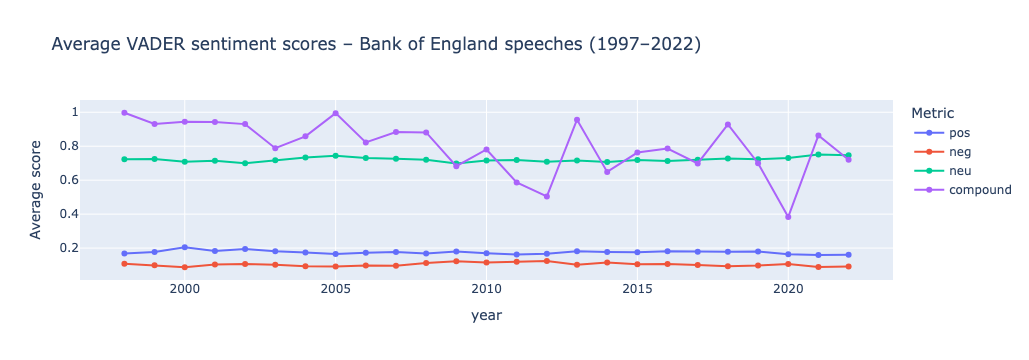

In [180]:
# Average VADER sentiment per year
vader_yearly = boe_speeches.groupby("year")[["pos", "neg", "neu", "compound"]].mean().reset_index()
fig3 = px.line(
     vader_yearly,
     x="year",
     y=["pos", "neg", "neu", "compound"],
     title="Average VADER sentiment scores – Bank of England speeches (1997–2022)",
     labels={"value": "Average score", "variable": "Metric"},
)
fig3.update_traces(mode="lines+markers")
fig3.show()

The full-panel VADER plot provides a richer decomposition of the Bank’s language. Across the entire 1997-2022 window the neutral share (green) hovers close to 0.70—evidence that most sentences remain informational, as one would expect from a central-bank charged with projecting authority and clarity. Within the residual 30 % of “sentiment-bearing” content, the positive fraction (blue, ≈ 0.16-0.21) consistently outweighs the negative fraction (red, ≈ 0.09-0.12), yielding a strongly positive compound score (violet) that rarely dips below 0.50. Yet those dips line up precisely with the key stress episodes highlighted in the project brief: a first slide in 2008-09 during the global-financial crisis, a second in 2011-12 amid euro-area tensions, and the deepest drop in 2020 when Covid-19 struck. Each time, the Bank’s speeches became less upbeat (falling compound, rising negative share), but the neutral component remained dominant, signalling that the institution continued to anchor expectations through factual, measured communication. The rapid rebounds in 2013-14 and again in 2021 also illustrate how the Bank modulates its tone upward as soon as macro-financial conditions stabilise, reinforcing its mandate to reassure markets while supporting the United Kingdom’s monetary and financial stability.

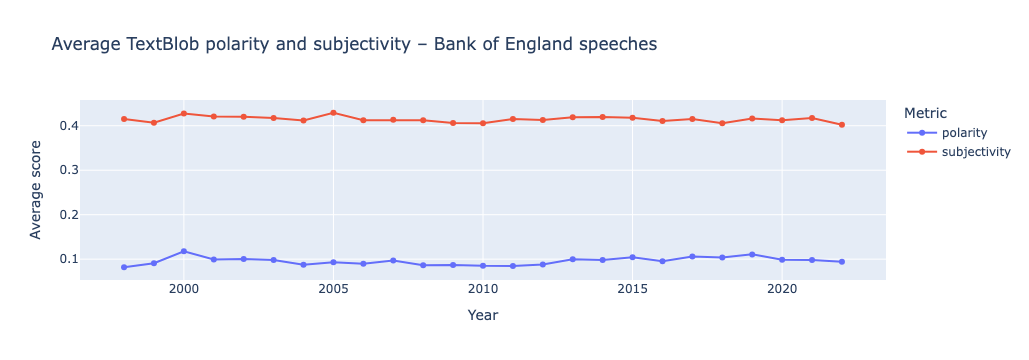

In [204]:
# Polarity & subjectivity 
fig_tb_combo = px.line(
    tb_yearly.reset_index(),            
    x="year",
    y=["polarity", "subjectivity"],
    title="Average TextBlob polarity and subjectivity – Bank of England speeches",
    labels={"value": "Average score", "variable": "Metric", "year": "Year"},
)
fig_tb_combo.update_traces(mode="lines+markers")
fig_tb_combo.show()

The TextBlob results confirm that, in fulfilling its mandate to “promote the good of the people of the United Kingdom by maintaining monetary and financial stability,” the Bank of England adopts a remarkably steady rhetorical stance. Average polarity (blue line) stays modestly positive—between ≈ 0.08 and 0.11—for the entire 1997-2022 sample, signalling a deliberately reassuring tone that fits the Bank’s role as an anchor for market expectations. The small but clear troughs in 2001-03 (post-dot-com slowdown), 2008-12 (global-financial and euro-area crises) and 2020 (COVID-19 shock) show that even this cautious measure registers periods of heightened concern, before rebounding as conditions stabilise—evidence that the Bank’s communications react to macro-financial stress but avoid excessive pessimism.

By contrast, subjectivity (orange line) hovers narrowly around 0.40-0.43 throughout. In practical terms this means that roughly 60 % of each speech is factual or data-driven while the remaining 40 % contains interpretative or forward-looking statements. The near-flat profile—barely affected by the crises noted above—suggests that, whatever the economic backdrop, the Bank maintains a consistent mix of analysis and judgement in its public messaging. This stylistic stability is fully aligned with its strategic objective: to provide markets and households with dependable guidance, neither overly technical nor unduly emotive, thereby supporting monetary-policy credibility and overall financial stability.

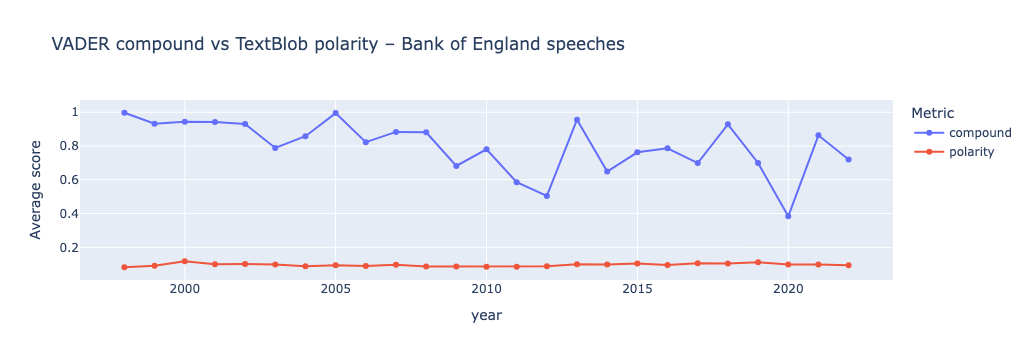

In [192]:
# Compound and Polarity 
combo = vader_yearly.merge(tb_yearly, on="year")

fig_combo = px.line(
    combo,
    x="year",
    y=["compound", "polarity"],
    title="VADER compound vs TextBlob polarity – Bank of England speeches",
    labels={"value": "Average score", "variable": "Metric"}
)
fig_combo.update_traces(mode="lines+markers")
fig_combo.show()

The combined plot of VADER compound (blue) and TextBlob polarity (red) summarises how the overall tone of Bank-of-England speeches has evolved since 1998. Although the two indices are reported on the same vertical axis, their scales differ: VADER’s non-linear formula pushes values close to +1 whenever positive language dominates, whereas TextBlob remains tightly compressed (≈ 0.07–0.12). For that reason we interpret the curves in terms of directional changes, not absolute height.

Both series move in lock-step: plateaus at high levels through the late-1990s and early-2000s; an unmistakable dip during the global-financial crisis (2007-09); a second trough in 2011-12 as euro-area turmoil intensified; and a sharp collapse in 2020 at the onset of the Covid-19 shock, followed by an incomplete rebound in 2021-22. The fact that the “quiet” polarity line tracks every rise and fall in the more volatile compound line confirms that the signal is real rather than a model artefact. In practical terms, VADER offers a high-resolution “early-warning” indicator, while TextBlob provides a stable baseline for long-run trend analysis. Taken together, the two metrics show that the Bank consistently adopts a mildly positive tone, yet still modulates that tone noticeably in response to major episodes of macro-financial stress, exactly as one would expect from an institution whose communications are meant to reassure markets while reflecting underlying economic realities.